# K-Means Land Classification with Dask
A common machine learning approach to geospatial data is classifying land – this can be roughly estimated be using a K-Means model.  

To help you with that KNN notebook, I recently built a K-Means-Dask notebook for GCT. KNN is a supervised classification, whereas K-Means is unsupervised - so, if you did KNN, you’d have to pick N-points and classify them manually before having the KNN predict over an entire raster. When we envisioned this, I was thinking K-Means and called it the wrong thing, sorry. We want a K-Means model. 
 
Use the K-Means notebook below to help you along but you need to use data that *isn’t* part of a project (that drone data is 30cm/px and an interesting case). It would be pretty interesting to do a large area, say, four (square) S2 L2A tiles (10m) which you’d have to create a clean composite (say, May 1st to September 31st queried with STAC), mosaic them together, and have the K-Means model cluster. Of course, start with a single tile and scaling up is easy for you now ;)  
 
The important factors are leveraging different indices for clustering (like NDVI, NDWI, and whatever else makes sense to include) to help make more accurate cluster predictions and also how we interpret the cluster output. Usually, we’d use those classifications and, if accurate enough, would feed clips into a Random Forest model to make more accurate predictions (this is what Barry is doing with GCT post-my-part). That’s out of scope for this but good to know what it’d be used for. 
 
Cooking shows be like: “Here’s one we made earlier"
https://git.hatfieldgroup.net/Hatfield_Geomatics/gct10314/-/blob/dev/KMeans-drone_investigation.ipynb 
 
To summarize:
- edit the notebook to use S2 L2A (10m)
- create a seasonal composite (May to Sept) of S2 tile
- create indices (NDVI, NDWI, etc…)
- convert data array into data frame (use the existing reshape and insert functions)
- process through K-Means 
- visualize output 
- scale to more tiles to simulate large AOI’s 
 
Of course, any questions, let me know, and we can definitely have a meeting after the holiday to go over the notebook, too. 
 
Jason - do you have any particular AOI you’d want to see?

## 1. Initialize Dask Cluster

In [1]:
import dask
import dask.distributed
from dask_gateway import Gateway
from dask.distributed import wait, progress

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
gateway = Gateway()
gateway.list_clusters()

[]

In [3]:
clusters = gateway.list_clusters()
cluster = gateway.connect(clusters[0].name, shutdown_on_close=True)
client = cluster.get_client() 
cluster

In [85]:
gateway = Gateway()
#cluster = gateway.new_cluster(options)
#cluster = gateway.new_cluster(image='pangeo/pangeo-notebook:2021.07.17')
cluster = gateway.new_cluster(image='pangeo/pangeo-notebook:2021.11.09')
# Scale the cluster
workers = 120
cluster.scale(workers) 
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 
cluster

In [79]:
cluster.scale(120)

In [82]:
cluster

## Query using the SentinelSat API

To get the data in our Area of Interest (AOI) within a specified time range, we will use the SentinelSat API (Temporarily until we have our Hatfield STAC fully-functional, since the Sentinel 2 Data is not added yet).

In [5]:
!pip install sentinelsat

     |████████████████████████████████| 48 kB 3.6 MB/s eta 0:00:011


In [6]:
# Import all the necessary modules

import yaml
import os
import glob
import rasterio
import fiona
import shapely.geometry
import datetime
import scipy
import gcsfs
import json

import xarray as xr
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from rioxarray.merge import merge_arrays
from shapely.geometry import mapping,Polygon
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from matplotlib.colors import ListedColormap
from datetime import date
from datetime import datetime

In [7]:
# Load the yaml file containing the authentication to your SentinelSat account
envvars = open('data/SS_config.yml' ,'r')
secrets = yaml.load(envvars, Loader=yaml.FullLoader)
envvars.close()

## 2. Functions 
### 2.1 Preparing the Data

In [14]:
bounding_box = (-120.5804,58.0139,-119.6521,58.3556)
#bounding_box = (-122.442627,58.447733,-120.992432,59.285526)

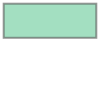

In [15]:
polygon = shapely.geometry.box(*bounding_box, ccw=True)
polygon

In [11]:
fp = '/home/jovyan/geoanalytics_user_shared_data/CSA10332/caribou-aoi/GCBP_CARIB_polygon.shp'
gdf = gpd.read_file(fp)
gdf[gdf['CAR_TAG'] == 'Snake-Sahtaneh']

,CAR_POP_ID,CAR_TAG,HERD_NO,HERD_STAT,HERD_NAME,ECOTYPE,RISK_STAT,STMTDCRBPP,YR_F_LST_Y,FEAT_CODE,OBJECTID,AREA_SQM,FEAT_LEN,geometry
21,1909,Snake-Sahtaneh,64,Herd,Snake-Sahtaneh,Boreal,Blue/Threatened,321 (minimum count),2013,FF84630000,141.0,1.200705e+10,741286.9932,None


In [17]:
def query_sentinel(username, password, footprint, start_date, end_date, max_cloud_cover):
    # Validate credentials for API access
    api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus')
    products = api.query(footprint,
                         date=(start_date, end_date),
                         platformname='Sentinel-2',
                         producttype='S2MSI1C',
                         cloudcoverpercentage=(0, max_cloud_cover))

    # Convert to Pandas DataFrame
    products_df = api.to_dataframe(products)
    # Remove rows with NaN for Tile ID and sort by ascending cloud cover
    df = products_df[products_df['tileid'].notna()].sort_values(['beginposition','cloudcoverpercentage'], ascending=[True,True])
    
    df = df.drop_duplicates(subset=['beginposition', 'tileid'], keep='first')
    

    # Only return dataframe with specific columns
    final_df = df[['title', 'beginposition', 'relativeorbitnumber', 'cloudcoverpercentage', 'tileid']].reset_index(drop=True)
    
    return final_df

In [47]:
start_date = '20210501'
end_date = '20210730'
query_df = query_sentinel(secrets['SENTINELSAT_USER'], secrets['SENTINELSAT_PASS'], polygon, start_date, end_date, 30)

In [48]:
query_df

,title,beginposition,relativeorbitnumber,cloudcoverpercentage,tileid
0,S2A_MSIL1C_20210511T192911_N0300_R142_T11VLE_2...,2021-05-11 19:29:11.024,142,11.4487,11VLE
1,S2A_MSIL1C_20210521T192911_N0300_R142_T11VLE_2...,2021-05-21 19:29:11.024,142,26.3831,11VLE
2,S2B_MSIL1C_20210523T191909_N0300_R099_T10VFK_2...,2021-05-23 19:19:09.024,99,21.5361,10VFK
3,S2A_MSIL1C_20210531T192911_N0300_R142_T11VLE_2...,2021-05-31 19:29:11.024,142,0.0000,11VLE
4,S2B_MSIL1C_20210605T192909_N0300_R142_T11VLE_2...,2021-06-05 19:29:09.024,142,21.0096,11VLE
5,S2A_MSIL1C_20210610T192911_N0300_R142_T11VLE_2...,2021-06-10 19:29:11.024,142,19.3655,11VLE
6,S2B_MSIL1C_20210619T190919_N0300_R056_T11VLE_2...,2021-06-19 19:09:19.024,56,1.1197,11VLE
7,S2B_MSIL1C_20210619T190919_N0300_R056_T10VFK_2...,2021-06-19 19:09:19.024,56,1.5295,10VFK
8,S2A_MSIL1C_20210620T192911_N0300_R142_T10VFK_2...,2021-06-20 19:29:11.024,142,10.9192,10VFK
9,S2B_MSIL1C_20210625T192909_N0300_R142_T11VLE_2...,2021-06-25 19:29:09.024,142,0.0000,11VLE


In [49]:
query_df['tileid'].unique()

array(['11VLE', '10VFK'], dtype=object)

In [50]:
def get_sentinel_data(input_df, bands_wanted):
    # 1. Create dataframe to store the path to the granules we want
    df = pd.DataFrame()
    
    # 2. Iterate through the queried dataframe and store the file paths to the desired bands in a new dataframe. 
    for i,row in input_df.iterrows():
        # if row['relativeorbitnumber'] != 50:
        #     continue
        # Variables representing subdirectories to obtain the filepaths
        tile = row['tileid']
        title = row['title']
        img_title = row['title'][11:19]
        utm = tile[0:2]
        latitude = tile[2]
        direction = tile[3:5]
        dir_path = f'/home/jovyan/gcp-public-data-sentinel-2/L2/tiles/{utm}/{latitude}/{direction}/*{img_title}*/GRANULE/*'
        if not glob.glob(dir_path): # check if folder exists
            continue
        # Get SCL Mask
        scl_path = glob.glob(f'/home/jovyan/gcp-public-data-sentinel-2/L2/tiles/{utm}/{latitude}/{direction}/*{img_title}*/GRANULE/*/IMG_DATA/R20m/*SCL*.jp2') 
        if not scl_path: # check if SCL exists
            continue      
        scl_path[0] = scl_path[0].replace('/home/jovyan/','https://storage.googleapis.com/')
        
        row_dict = {'date': row['beginposition'], 
                    'cloud_cover' : row['cloudcoverpercentage'], 
                    'tile_ID': row['tileid'], 
                    'SCL': scl_path[0]}
        
        #Iterate through the list of input bands and store the filepath in a dictionary 
        for band in bands_wanted:
            filepath = glob.glob(f'{dir_path}/IMG_DATA/R10m/*{band}*.jp2')  
            filepath[0] = filepath[0].replace('/home/jovyan/','https://storage.googleapis.com/')
            row_dict.update({band:filepath[0]})
        # Add the dictionary as a dataframe row
        df = df.append(row_dict,ignore_index=True)

    return df

In [51]:
bands_wanted = ['B02', 'B03', 'B04', 'B08']
df = get_sentinel_data(query_df, bands_wanted)

In [52]:
df

,date,cloud_cover,tile_ID,SCL,B02,B03,B04,B08
0,2021-05-11 19:29:11.024,11.4487,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
1,2021-05-21 19:29:11.024,26.3831,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
2,2021-05-23 19:19:09.024,21.5361,10VFK,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
3,2021-05-31 19:29:11.024,0.0000,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
4,2021-06-05 19:29:09.024,21.0096,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
5,2021-06-10 19:29:11.024,19.3655,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
6,2021-06-19 19:09:19.024,1.1197,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
7,2021-06-19 19:09:19.024,1.5295,10VFK,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
8,2021-06-20 19:29:11.024,10.9192,10VFK,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...
9,2021-06-25 19:29:09.024,0.0000,11VLE,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...,https://storage.googleapis.com/gcp-public-data...


## 2. Loading, Masking, and Creating Mosaics

The `get_band_images()` function loads the band granule and masks out the cloud pixels.

In [25]:
@dask.delayed()
def open_ras(pth,bandname=None, chunks=None):
    img = xr.open_rasterio(pth, chunks=chunks)
    img.attrs['nodatavals'] = (0,)
    img['band'] = [bandname]
    return img



In [26]:
@dask.delayed()
def mask_ras(b, scl):
    masked = xr.where((scl.data == 0)   # no data
                          | (scl.data == 1)   # saturated
                          | (scl.data == 3)   # cloud shadows
                          | (scl.data == 8)  # cloud medium probability
                          | (scl.data == 9)  # cloud high probability
                          | (scl.data == 10) # thin cirrus
                          , np.nan, b.data)
    # snow mask
   # snow_masked = xr.where((scl.data == 11), -1111, masked)
    b.data = masked
    return b

In [147]:
@dask.delayed
def merge_band(bandN):
    merged = merge_arrays(bandN)
    merged = merged.astype(np.float32)
    return merged.chunk('auto')
    # return merge_arrays(bandN).chunk('auto')
    

In [31]:
@dask.delayed
def projecting(array, change_res=False):
    import rasterio
    import rioxarray
    import xarray
    if change_res == True:
        reproj = array.rio.reproject('EPSG:4326', resolution=(10,10))
    else:
        reproj = array.rio.reproject('EPSG:4326')
    return reproj

In [32]:
@dask.delayed
def clipping(array, poly):
    import rasterio
    import rioxarray
    import xarray
    #bbox = np.array(poly.bounds)[0]
    bbox = np.array(poly.bounds)
    print(array.shape)
    return array.rio.clip_box(*bbox)

In [137]:
@dask.delayed()
def clean_array(arr):
    arr.data = da.where((arr.data == -9999), np.nan, arr.data)
    return arr

In [34]:
@dask.delayed
def concat_list(lst, dimension):
    return xr.concat(lst, dim=dimension)

In [35]:
@dask.delayed
def date_layer(ref_band, date):
    int_date = time_to_int(date)

    time_band = ref_band.copy()
    replace = np.zeros(ref_band.data.shape)
    replace[(replace == 0)] = int_date
    replace = np.where(np.isnan(ref_band.data),np.nan,replace)
    time_band.data = replace
    time_band['band'] = ['date']
    return time_band   

In [36]:
def time_to_int(vals):
    timestamp = vals.astype(object)
    date = datetime.fromtimestamp(timestamp / 1e9)
    year = date.year
    month = date.month
    day = date.day
    if month < 10:
        month = '0' + str(month)
    else:
        month = str(month)
    if day < 10:
        day = '0' + str(day)
    else:
        day = str(day)
    return int(str(year) + month + day)

In [120]:
def normalize(array):
    norm = (array - array.min()) / (array.max() - array.min())
    return norm


def color_composite(ds, col1, col2, col3, scale):
    # Stack the bands 4,3,2 for a true color composite
    np_color = da.dstack((normalize(ds.sel(band=col1)), 
                         normalize(ds.sel(band=col2)), 
                         normalize(ds.sel(band=col3))))*scale

    col_comp_ds = ds.sel(band=[col1,col2,col3]).transpose('y','x','band')
    col_comp_ds.data = np_color
    
    return col_comp_ds

In [155]:
def create_mosaics(wanted_bands, df):
    
    tile_count = len(df.tile_ID.unique())
    dates = df.date.unique()
    total = []
    date_dict = {}
    total_SCL = []
    for date in dates:
        each_date_list = []
        # Create a sub-dataframe with only the same date rows
        df_date = df[(df.date == date)]
        if tile_count != len(df_date): # If the date doesnt have all the tiles needed to create a mosaic, skip date
            dates = dates[dates != date]
            continue

        bands = defaultdict(list)
        # 1. Open the raster bands
       #  SCL_list = [open_ras(pth, 'SCL', chunks={'band': 1, 'y':'auto', 'x':'auto'}) for pth in df_date['SCL'].values] 
       #  projected_scl = [projecting(scls, True) for scls in SCL_list] 
       #  merged_SCL = merge_band(projected_scl)
       # # clipped_SCL = clipping(merged_SCL, polygon)
       #  # Clean up and remove the nan values from the array
       #  cleaned_scl = clean_array(merged_SCL)

        for b in wanted_bands:
            bands[b] = [open_ras(pth, b, 'auto') for pth in df_date[b].values]
            bands[b] = [projecting(bnd) for bnd in bands[b]] 
            bands[b] = merge_band(bands[b])
           # bands[b] = clipping(bands[b], polygon)
            bands[b] = clean_array(bands[b])
       #     bands[b] = mask_ras(bands[b], cleaned_scl)
            each_date_list.append(bands[b])
            
        # date_band = date_layer(bands[b], date)
        # each_date_list.append(date_band)
        
         # concatenate all the bands together
        concat_bands = concat_list(each_date_list, 'band')
        total.append(concat_bands)
        #break
    
    return total, dates

In [156]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: http://traefik-dask-gateway.geoanalytics.ca/services/dask-gateway/clusters/pangeo.b1a354b2a0fe4160a98f353a66e28a82/status,


In [157]:
mosaic_arrays, dates = create_mosaics(bands_wanted, df)

In [158]:
dates

array(['2021-06-19T19:09:19.024000000', '2021-06-25T19:29:09.024000000',
       '2021-06-27T19:19:11.024000000', '2021-06-29T19:09:19.024000000',
       '2021-06-30T19:29:11.024000000', '2021-07-05T19:29:09.024000000',
       '2021-07-09T19:09:19.024000000', '2021-07-24T19:09:21.024000000',
       '2021-07-25T19:29:09.024000000', '2021-07-29T19:09:19.024000000'],
      dtype='datetime64[ns]')

In [159]:
%%time
computed_mosaic_da = dask.compute(mosaic_arrays)

CPU times: user 36.6 s, sys: 49.5 s, total: 1min 26s
Wall time: 3min 32s


In [161]:
computed_mosaic_da

([<xarray.DataArray (band: 4, y: 7404, x: 20309)>
  dask.array<concatenate, shape=(4, 7404, 20309), dtype=float32, chunksize=(1, 3702, 5792), chunktype=numpy.ndarray>
  Coordinates:
    * x            (x) float64 -121.3 -121.3 -121.3 ... -118.5 -118.5 -118.5
    * y            (y) float64 58.63 58.63 58.63 58.63 ... 57.61 57.61 57.61 57.61
    * band         (band) <U3 'B02' 'B03' 'B04' 'B08'
      spatial_ref  int64 0
  Attributes:
      scales:      (1.0,)
      offsets:     (0.0,)
      _FillValue:  0,
  <xarray.DataArray (band: 4, y: 7404, x: 20309)>
  dask.array<concatenate, shape=(4, 7404, 20309), dtype=float32, chunksize=(1, 3702, 5792), chunktype=numpy.ndarray>
  Coordinates:
    * x            (x) float64 -121.3 -121.3 -121.3 ... -118.5 -118.5 -118.5
    * y            (y) float64 58.63 58.63 58.63 58.63 ... 57.61 57.61 57.61 57.61
    * band         (band) <U3 'B02' 'B03' 'B04' 'B08'
      spatial_ref  int64 0
  Attributes:
      scales:      (1.0,)
      offsets:     (0.0,)


In [124]:
rgb = color_composite(concated, 'B04', 'B03', 'B02', 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


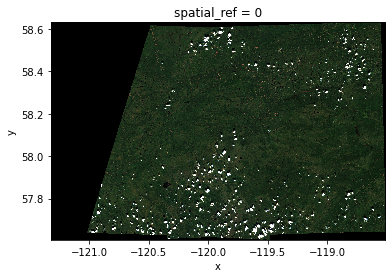

In [125]:
rgb.plot.imshow()

In [115]:
np.unique(b2)

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.2024e+04, 1.2128e+04,
       1.2200e+04])

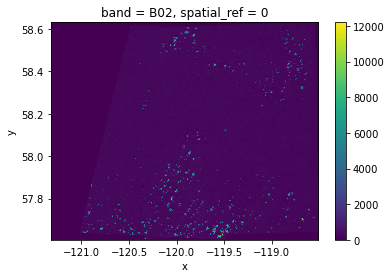

In [116]:
concat[0].plot.imshow()

In [166]:
#@dask.delayed
def get_comp(dates_array, dates):
    # Concat all the Arrays along the dimension based on the dates
    dates_ds = xr.concat(dates_array[0], dim=pd.DatetimeIndex(dates, name='time'))
    dates_ds.data[(dates_ds.data == -9999)] = np.nan # Change Fill Value to NaN
    
    return dates_ds

In [168]:
comp = get_comp(computed_mosaic_da, dates)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [169]:
comp

,Array,Chunk
Bytes,93.56 GiB,327.34 MiB
Shape,"(10, 4, 15129, 41502)","(1, 1, 7565, 11343)"
Count,6896 Tasks,840 Chunks
Type,float32,numpy.ndarray


In [74]:
computed_composite = comp.compute()

KeyError: 'data'

In [170]:
def get_median(dates_ds):
    # Compute the Median (skipping pixels with NaN)
    median_ds = dates_ds.median(dim='time', skipna=True)
    
    return median_ds

In [171]:
med_ds = get_median(comp)

In [173]:
np.unique(med_ds)

array([0.000e+00, 5.000e-01, 1.000e+00, ..., 7.159e+03, 7.176e+03,
             nan], dtype=float32)

In [182]:
med_ds.chunk('auto')

<xarray.DataArray (band: 4, y: 15129, x: 41502)>
dask.array<rechunk-merge, shape=(4, 15129, 41502), dtype=float32, chunksize=(2, 2666, 5032), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -121.3 -121.3 -121.3 ... -118.5 -118.5 -118.5
  * y            (y) float64 57.61 57.61 57.61 57.61 ... 58.63 58.63 58.63 58.63
  * band         (band) <U3 'B02' 'B03' 'B04' 'B08'
    spatial_ref  int64 0

In [181]:
med_ds.rio.to_raster('median_composite.tif')

RasterioIOError: median_composite.tif: Free disk space available is 7437549568 bytes, whereas 10046140128 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.

In [174]:
rgb_comp = color_composite(med_ds, 'B04', 'B03', 'B02', 5)

In [175]:
rgb_comp.plot.imshow()

KeyboardInterrupt: 

In [42]:
cluster.close()